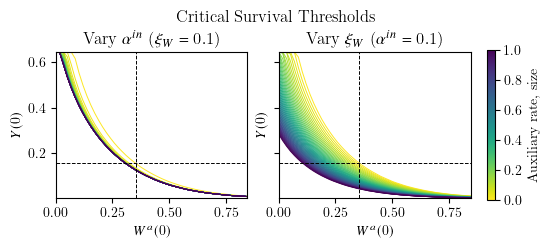

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl


# LaTeX: Times-like math (newtxmath) + Computer Modern text
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['CMU Serif', 'Computer Modern Roman', 'DejaVu Serif', 'Times New Roman', 'Times']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath}'
# Legend appearance: slightly opaque background
mpl.rcParams['legend.framealpha'] = .8
# PGF export configuration (pdflatex + newtxmath)
mpl.rcParams['pgf.texsystem'] = 'pdflatex'
mpl.rcParams['pgf.preamble'] = r'\usepackage{newtxmath}'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

width_pt = 390
inches_per_pt = 1.0/72.27
golden_ratio = (5**.5 - 1) / 2  # aesthetic figure height

fig_width = width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_ratio # height in inches
def simulate_population(W0, Y0,
                        W_birth, Y_birth, W_death, Y_death,
                        X_size, X_rate,
                        Time, use_X=True, dt=0.01):
    """
    Integrate the ODEs via Euler. X0 is set internally to match capacity: X0 = upper_W * X_size.
    Survival is when final W is closer to upper_W than to 0.
    """
    # Equilibria
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    else:
        upper_W = np.nan; lower_W = np.nan
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    else:
        upper_Y = np.nan; lower_Y = np.nan

    # Initial conditions
    X0 = upper_W * X_size
    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t); Y = np.zeros_like(t); X = np.zeros_like(t)
    W[0], Y[0], X[0] = W0, Y0, X0

    for i in range(1, len(t)):
        dW = -W_birth * W[i-1]**2 * Y[i-1] + W_birth * W[i-1] * Y[i-1] - W_death * W[i-1]
        dY = -Y_birth * Y[i-1]**2 * W[i-1] + Y_birth * W[i-1] * Y[i-1] - Y_death * Y[i-1]
        if use_X:
            dW -= X_rate * (W[i-1] - (X[i-1] / X_size))
        dX = X_rate * (W[i-1] - (X[i-1] / X_size))
        W[i] = W[i-1] + dt * dW
        Y[i] = Y[i-1] + dt * dY
        X[i] = X[i-1] + dt * dX

    return np.abs(W[-1] - upper_W) < np.abs(W[-1] - 0)


def find_critical_Y(W0,
                    W_birth, Y_birth, W_death, Y_death,
                    X_size, X_rate,
                    Time, use_X=True,
                    tol=1e-3, max_iter=20, dt=0.01):
    """
    Binary search Y0* in [0, upper_Y] such that Y0 < Y0* => extinction; Y0 >= Y0* => survival.
    """
    # Equilibria for bounds
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return 0.0
    upper_Y = 0.5 * ((1 - Q2 + Q1) + np.sqrt(disc_Y))

    outcome_low = simulate_population(W0, 0.0, W_birth, Y_birth, W_death, Y_death, X_size, X_rate, Time, use_X, dt)
    outcome_high = simulate_population(W0, upper_Y, W_birth, Y_birth, W_death, Y_death, X_size, X_rate, Time, use_X, dt)
    if outcome_low:
        return 0.0
    if not outcome_high:
        return upper_Y

    low, high = 0.0, upper_Y
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        if simulate_population(W0, mid, W_birth, Y_birth, W_death, Y_death, X_size, X_rate, Time, use_X, dt):
            high = mid
        else:
            low = mid
        if high - low < tol:
            break
    return high


def plot_threshold_lines(ax, num_lines=10, n_points=50,
                         W_birth=1.0, Y_birth=1.0, W_death=0.3, Y_death=0.3,
                         fixed_size=0.1, rate_min=0, rate_max=2,
                         Time=50, dt=0.01, tol=1e-3, max_iter=20):
    """Vary X_rate (0..2) with fixed X_size; plot threshold curves."""
    # Equilibria for W,Y
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None
    upper_W = 0.5 * ((1 - Q1 + Q2) + np.sqrt(disc_W))
    lower_W = 0.5 * ((1 - Q1 + Q2) - np.sqrt(disc_W))
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None
    upper_Y = 0.5 * ((1 - Q2 + Q1) + np.sqrt(disc_Y))
    lower_Y = 0.5 * ((1 - Q2 + Q1) - np.sqrt(disc_Y))

    W0_values = np.linspace(0, upper_W, n_points)
    rate_values = np.linspace(rate_min, rate_max, num_lines)
    cmap = plt.cm.viridis_r
    norm = plt.Normalize(vmin=0, vmax=1)

    threshold_lines = []
    for rate in rate_values:
        line = np.zeros_like(W0_values)
        for i, W0 in enumerate(W0_values):
            line[i] = find_critical_Y(W0, W_birth, Y_birth, W_death, Y_death, fixed_size, rate, Time, True, tol, max_iter, dt)
        threshold_lines.append(line)
        ax.plot(W0_values, line, color=cmap(norm(rate)), linewidth=.7)

    ax.axvline(x=lower_W, color='black', linestyle='--', linewidth=.7)
    ax.axhline(y=lower_Y, color='black', linestyle='--', linewidth=.7)
    ax.set_xlabel(r'$W^a(0)$')
    ax.set_ylabel(r'$Y(0)$')
    ax.set_title(r'Vary $\alpha^{in}$ ($\xi_W=0.1$)')

    y_min = min([np.min(line) for line in threshold_lines])
    y_max = max([np.max(line) for line in threshold_lines])
    return W0_values, threshold_lines, lower_W, lower_Y, upper_W, upper_Y, y_min, y_max


def plot_threshold_lines_size(ax, num_lines=10, n_points=50,
                              W_birth=1.0, Y_birth=1.0, W_death=0.3, Y_death=0.3,
                              min_size=0, max_size=2, fixed_rate=0.1,
                              Time=50, dt=0.01, tol=1e-3, max_iter=20):
    """Vary X_size (0..2) with fixed X_rate; plot threshold curves."""
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None
    upper_W = 0.5 * ((1 - Q1 + Q2) + np.sqrt(disc_W))
    lower_W = 0.5 * ((1 - Q1 + Q2) - np.sqrt(disc_W))
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None
    upper_Y = 0.5 * ((1 - Q2 + Q1) + np.sqrt(disc_Y))
    lower_Y = 0.5 * ((1 - Q2 + Q1) - np.sqrt(disc_Y))

    W0_values = np.linspace(0, upper_W, n_points)
    size_values = np.linspace(min_size, max_size, num_lines)
    cmap = plt.cm.viridis_r
    norm = plt.Normalize(vmin=0, vmax=1)

    threshold_lines = []
    for size in size_values:
        line = np.zeros_like(W0_values)
        for i, W0 in enumerate(W0_values):
            line[i] = find_critical_Y(W0, W_birth, Y_birth, W_death, Y_death, size, fixed_rate, Time, True, tol, max_iter, dt)
        threshold_lines.append(line)
        ax.plot(W0_values, line, color=cmap(norm(size)), linewidth=.7)

    ax.axvline(x=lower_W, color='black', linestyle='--', linewidth=.7)
    ax.axhline(y=lower_Y, color='black', linestyle='--', linewidth=.7)
    ax.set_xlabel(r'$W^a(0)$')
    ax.set_ylabel(r'$Y(0)$')
    ax.set_title(r'Vary $\xi_W$ ($\alpha^{in}=0.1$)')

    y_min = min([np.min(line) for line in threshold_lines])
    y_max = max([np.max(line) for line in threshold_lines])
    return W0_values, threshold_lines, lower_W, lower_Y, upper_W, upper_Y, y_min, y_max


# ---- Compose figure ----
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height*.7), sharex=True, sharey=True, constrained_layout=True)

# Parameters
W_birth = 1.0; Y_birth = 1.0; W_death = 0.1; Y_death = 0.3; Time = 50

left = plot_threshold_lines(axs[0], num_lines=50, n_points=50,
                            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
                            fixed_size=0.1, rate_min=0.001, rate_max=1, Time=Time)
right = plot_threshold_lines_size(axs[1], num_lines=50, n_points=50,
                                  W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
                                  min_size=0.001, max_size=1, fixed_rate=0.1, Time=Time)

# Unify axes
vals = [v for v in (left, right) if v is not None]
if vals:
    x_max = max(v[4] for v in vals)
    y_min = min(v[6] for v in vals); y_max = max(v[7] for v in vals)
    for ax in axs:
        ax.set_xlim(0, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal', adjustable='box')

# Shared colorbar (0..2)
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
fig.colorbar(sm, ax=axs.ravel().tolist(), location='right', fraction=0.046, pad=0.04, label='Auxiliary rate, size')

fig.suptitle('Critical Survival Thresholds', fontsize=12)
fig.savefig('survReg_two_plots.pdf', bbox_inches='tight', dpi=300)
plt.show()
